# SEM Image Analysis Notebook

## Notebook Description

This notebook walks through how to analzye and quantify the line-space metric of an electron-beam photolitography pattern collected via SEM.
This notebook will act as the foundation for future .py automated scripts to handle high-throughput analysis.
<br> The images provided are snipped from the publication Gian Francesco Lorusso et al 2023 Jpn. J. Appl. Phys. 62 SG0808
<br> Each image is taken at the indicated landing energy during the e-beam lithography process
<br> As a result, the image quality is reduced for our analysis.

### Ingestion and Exploration

- We begin by importing necessary dependencies and displaying the original image
- This image has 568x568 pixels, with each pixel having an array of 4 numbers to denote color and alpha (i.e. [R, G, B, A])
- The nice thing here is we can treat images as numpy arrays as you'll see later

Type: <class 'numpy.ndarray'>
dtype: uint8
shape: (573, 575, 4)


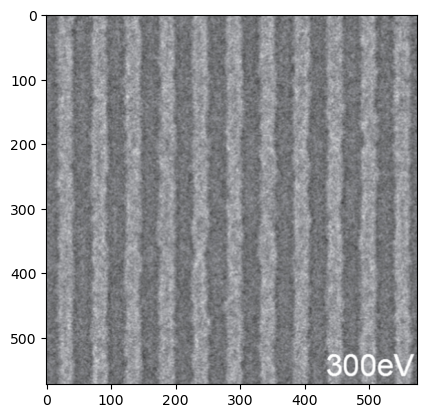

In [13]:
# dependencies
import numpy as np
from skimage import io, data, color, img_as_float
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, savgol_filter
import pandas as pd

# upload the image using skimage
image = io.imread('SEM_image_300eV.png')

# print image details
print("Type:", type(image))
print("dtype:", image.dtype)
print("shape:", image.shape)

# plot the data
plt.imshow(image);

- Relevant metadata is often included in the SEM image at the bottom (e.g. length scale, scan details etc).
- For our purposes, we'll focus on just the image analysis, so we can truncate the bottom section of the figure.

shape: (500, 575, 4)


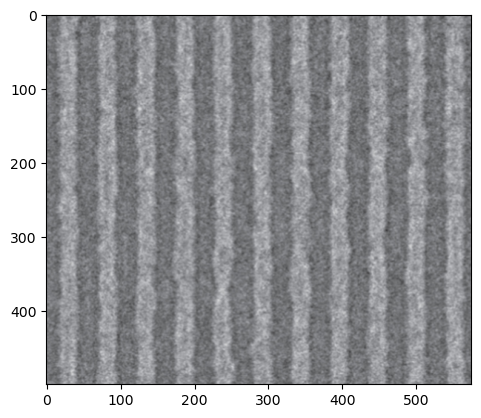

In [14]:
# crop out the bottom text
image = image[0:500,:]
print("shape:", image.shape)
plt.imshow(image);

We're interested in quantifying a line-space metric which is important for process uniformity.
<br> Let's take a look at how each pixel value (i.e. RGBA) varies across the X-axis

(0.0, 100.0)

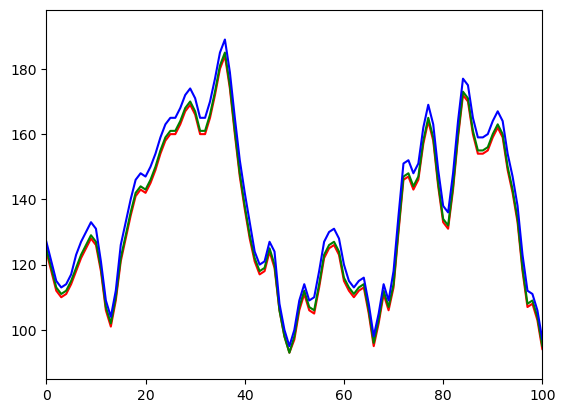

In [15]:

# function to grab a specific color spectrum value across a column of the image
def color_value(color,row):
    v=[]
    if color == 'R':
        c = 0
    elif color == 'G':
        c = 1
    elif color == 'B':
        c = 2

    for x in range(image.shape[1]):
        new = image[row,:,:][x][c]
        v = np.append(v,new)
    return v

# plot a single line scan for each color
plt.plot(color_value('R',100),color='red')
plt.plot(color_value('G',100),color='green')
plt.plot(color_value('B',100),color='blue')

plt.xlim(0,100)

- Overlaying the line scans confirms each color channel is relatively the same.
- We can anlayze the line scans of a single color since it is representative of the other colors.
- Additionally, if there were differences between the colors and alpha, we can collapse the RGBA in to a single representative scalar rather than binarize the data for analysis. This improves resolution and doesn't discard useful data.
- We will try both methods and see what the differences are.

### Horizontal Line Scans

- We will use the previous line scan function (i.e. color_value) to take a closer look at the periodicity of this single line scan
- We can increase statistics by analyzing all the line scans later

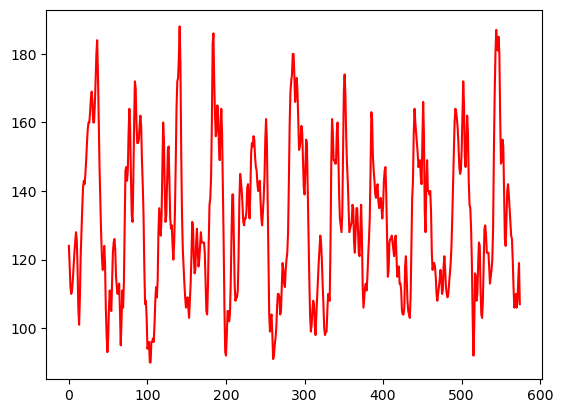

In [16]:
plt.plot(color_value('R',100),color='red');

- Not surprising.... we have some noisy data.
- We can clean this up with some smoothing filters (e.g. SGF or Gaussian)

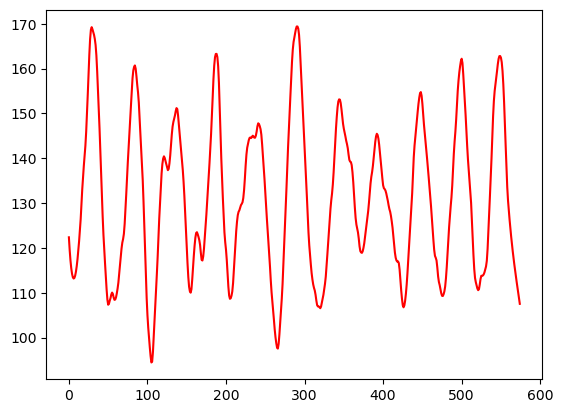

In [17]:
# data smoothing
R_smooth = savgol_filter(color_value('R',100), window_length=31, polyorder=3)
plt.plot(R_smooth,color='red');

- Now we can extract peak widths
- We'll extract the widths using the peak prominance and weight factor of 0.5 (i.e. relative height)
- We can ignore false peaks that fall under 130 and spacing closer than 35
- The blue x's indicated the peak locations and the output array is the width of each peak

array([19.82935919, 20.66669138, 31.07591936, 20.08548939, 34.89289892,
       23.26798187, 30.04606955, 21.04259178, 22.85209692, 20.76060245,
       20.77496917])

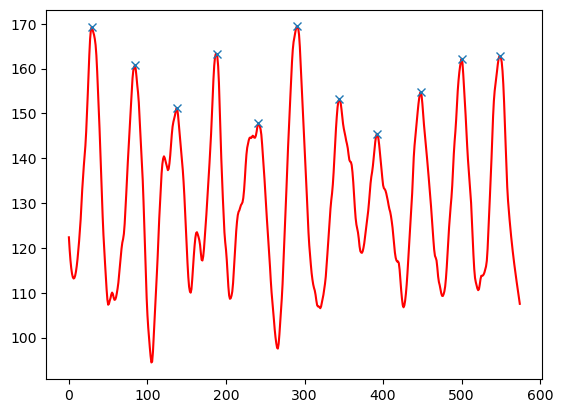

In [18]:
# find peaks
peaks, _ = find_peaks(R_smooth, prominence=5,height=130, distance=35)
plt.plot(R_smooth,color='red');
plt.plot(peaks, R_smooth[peaks],'x')

results = peak_widths(R_smooth, peaks, rel_height=0.5) 
peak_widths_px = results[0] # in pixels
peak_widths_px


-Based off our original image and line scan, we will drop the outermost peaks (left and right) since they may be cut off from the image and can scew analysis
-With this, the peak widths seem to be around 21 pixels wide, with some outliers

In [19]:
peak_widths_px = peak_widths_px[1:-1]
peak_widths_px

array([20.66669138, 31.07591936, 20.08548939, 34.89289892, 23.26798187,
       30.04606955, 21.04259178, 22.85209692, 20.76060245])

### Increasing Statistics

- So we've shown we can extract the peak widths from our image looking at a single row. Let's exapand this to look at all rows of the image
- We'll summarize all this into a DataFrame (df). Where rows correspond to image rows, and df coloumns correspond to specific peak number

In [20]:
def all_peak_width(rows):
    list = []
    for x in range(rows):
        
        # data smoothing
        R_smooth = savgol_filter(color_value('R',x), window_length=31, polyorder=3)
    
        # identify peaks
        peaks, _ = find_peaks(R_smooth, prominence=5)

        # identify peak widths
        results = peak_widths(R_smooth, peaks, rel_height=0.5) 
        peak_widths_px = results[0] # in pixels
        peak_widths_px = peak_widths_px[1:-1]
        list.append(peak_widths_px)
    df = pd.DataFrame(list)
    return df
df = all_peak_width(image.shape[0])
display(df)

,0,1,2,3,4,5,6,7,8,9,10,11
0,23.570976,22.549735,19.197137,20.597309,23.161135,21.547574,23.105920,28.008330,25.441043,NaN,NaN,NaN
1,22.277081,21.083664,19.558117,20.615316,21.389191,17.703894,24.432387,24.287677,25.290576,NaN,NaN,NaN
2,21.473098,19.714057,19.954908,19.888955,20.114705,17.659102,28.995954,22.235279,25.246538,NaN,NaN,NaN
3,22.331525,20.384330,19.076173,20.478616,19.511717,18.237585,30.524472,23.393380,24.734221,NaN,NaN,NaN
4,23.025236,23.632157,17.868640,20.301489,20.449042,18.505390,28.669791,26.134832,26.919928,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
495,21.394725,22.543523,15.682364,22.140469,26.674585,18.409113,19.644816,26.325660,19.927608,NaN,NaN,NaN
496,20.243182,20.869688,16.972595,22.419948,23.932057,17.736862,5.021821,17.806468,23.261722,21.024415,NaN,NaN
497,18.659365,20.741254,20.722192,19.164820,5.392207,22.267368,19.521322,17.759272,15.891108,20.341052,NaN,NaN
498,18.626932,23.131882,23.151916,18.591206,4.379669,24.460470,21.060040,13.952622,5.432689,18.996708,25.945265,NaN


- Looking at the df, we see that some rows have up to 12 peaks, but that is the minority. We'll delete columns that have NaN data
- Turns out 9 peaks is what is typically identified
- This approach is simplified, but can be modified to better capture 100% of peak values.

In [21]:
df.dropna(axis=1, how='any',inplace=True)
display(df)

,0,1,2,3,4,5,6,7,8
0,23.570976,22.549735,19.197137,20.597309,23.161135,21.547574,23.105920,28.008330,25.441043
1,22.277081,21.083664,19.558117,20.615316,21.389191,17.703894,24.432387,24.287677,25.290576
2,21.473098,19.714057,19.954908,19.888955,20.114705,17.659102,28.995954,22.235279,25.246538
3,22.331525,20.384330,19.076173,20.478616,19.511717,18.237585,30.524472,23.393380,24.734221
4,23.025236,23.632157,17.868640,20.301489,20.449042,18.505390,28.669791,26.134832,26.919928
...,...,...,...,...,...,...,...,...,...
495,21.394725,22.543523,15.682364,22.140469,26.674585,18.409113,19.644816,26.325660,19.927608
496,20.243182,20.869688,16.972595,22.419948,23.932057,17.736862,5.021821,17.806468,23.261722
497,18.659365,20.741254,20.722192,19.164820,5.392207,22.267368,19.521322,17.759272,15.891108
498,18.626932,23.131882,23.151916,18.591206,4.379669,24.460470,21.060040,13.952622,5.432689


- If we look at the histogram for peak '0', we can extract mean and standard deviations below

mean:20.65
std_dev:4.87


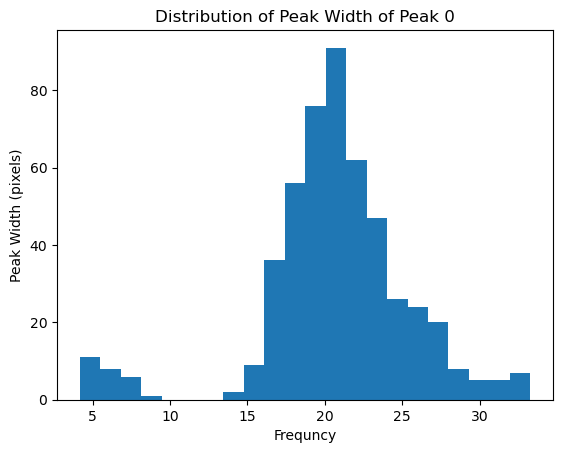

In [22]:
# get the first column values
peak0 = df[0]
# use the sqrt ruel for hist bin numbers
bins = round(np.sqrt(len(peak0)))
# plot everything
plt.hist(peak0, bins = bins );
plt.title('Distribution of Peak Width of Peak 0')
plt.xlabel('Frequncy')
plt.ylabel('Peak Width (pixels)')
# print mean and std
print('mean:{:0.2f}'.format(np.mean(peak0)))
print('std_dev:{:0.2f}'.format(np.std(peak0)))

- Again let's repeat this for all 8 peaks
- We'll put this in a df again, showing the mean_width and standard deviation for each of the 8 peaks

In [23]:
def get_peak_stats():
    stats = []
    for x in range(len(df.columns)):
        # get column values
        peak = df[x]
        # append mean and std
        stats.append([np.mean(peak),np.std(peak)])
    df_stats = pd.DataFrame(stats) 
    return df_stats
df_stats = get_peak_stats()
df_stats.columns = ['mean_width','std_dev']
display(df_stats)

,mean_width,std_dev
0,20.652911,4.865493
1,21.496265,4.561250
2,21.980866,5.344603
3,22.344432,4.681966
4,21.641524,5.351686
5,21.490353,4.325004
6,21.369459,4.942843
7,21.916133,4.673598
8,21.091161,4.940675


- If we want to quantify the lines of the entire image, we can output the average peak width and standard deviation
- If we rerun this entire analysis for each of the images, there are clear differences in mean and standard deviation which can be attributed to the processing conditions of the sample due to landing energy of e-beam lithography 

In [24]:
print('image mean width of peaks (pixels): {}'.format(np.mean(df_stats.mean_width)))
print('image mean standard deviation of peaks: {}'.format(np.mean(df_stats.std_dev)))

image mean width of peaks (pixels): 21.553678294207845
image mean standard deviation of peaks: 4.854124216817825
